In [35]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm
import torch
from weaver.utils.logger import _logger
from EfficientParticleTransformer import EfficientParticleTransformer
import scipy


In [2]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [3]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [4]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [5]:
tree = uproot.open('JetClass_example_100k.root')['tree']

In [6]:
table = build_features_and_labels(tree)


In [7]:
x_particles = table['pf_features']
x_jets = table['pf_vectors']
y = table['label']
x_points = table['pf_points']
x_mask = table['pf_mask']

In [8]:
r_indexes = np.arange(len(x_particles))
np.random.shuffle(r_indexes)


In [9]:
x_particles_train=x_particles[r_indexes][0:10000]
x_jets_train=x_jets[r_indexes][0:10000]
y_train=y[r_indexes][0:10000]
x_points_train=x_points[r_indexes][0:10000]
x_mask_train=x_mask[r_indexes][0:10000]

In [10]:
x_part_test=x_particles[r_indexes][20000:21000]
x_jet_test=x_jets[r_indexes][20000:21000]
y_test=y[r_indexes][20000:21000]
x_points_test=x_points[r_indexes][20000:21000]
x_mask_test=x_mask[r_indexes][20000:21000]

In [11]:
class EfficientParticleTransformerWrapper(torch.nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()
        self.mod = EfficientParticleTransformer(**kwargs)
        self.attention_matrix = None 
        self.interactionMatrix = None

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        output = self.mod(features, v=lorentz_vectors, mask=mask)
        self.attention_matrix = self.mod.getAttention()
        self.interactionMatrix = self.mod.getInteraction()
        return output
    
    def get_attention_matrix(self):
        return self.attention_matrix
    def get_interactionMatrix(self):
        return self.interactionMatrix
    


def get_model(**kwargs):

    cfg = dict(
        input_dim=17,
        num_classes=10,
        # network configurations
        pair_input_dim=4, # 4,
        use_pre_activation_pair=False,
        embed_dims=[64 , 64, 64],
        pair_embed_dims=[32, 32, 32],
        num_heads=1,
        num_layers=1,
        num_cls_layers=1,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = EfficientParticleTransformerWrapper(**cfg)

    model_info = {
      
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()

In [12]:
model, modInf = get_model()

2024-04-25 13:23:38 | INFO | weaver | Model config: {'input_dim': 17, 'num_classes': 10, 'pair_input_dim': 4, 'use_pre_activation_pair': False, 'embed_dims': [64, 64, 64], 'pair_embed_dims': [32, 32, 32], 'num_heads': 1, 'num_layers': 1, 'num_cls_layers': 1, 'block_params': None, 'cls_block_params': {'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0}, 'fc_params': [], 'activation': 'gelu', 'trim': True, 'for_inference': False}
2024-04-25 13:23:38 | INFO | weaver | cfg_block: {'embed_dim': 64, 'num_heads': 1, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
2024-04-25 13:23:38 | INFO | weaver | cfg_cls_block: {'embed_dim': 64, 'num_heads': 1, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_res

In [13]:
total_params = sum(p.numel() for p in model.parameters())


In [14]:
total_params

122715

In [15]:
model

EfficientParticleTransformerWrapper(
  (mod): EfficientParticleTransformer(
    (trimmer): SequenceTrimmer()
    (embed): Embed(
      (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (embed): Sequential(
        (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
        (1): Linear(in_features=17, out_features=64, bias=True)
        (2): GELU(approximate='none')
        (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (4): Linear(in_features=64, out_features=64, bias=True)
        (5): GELU(approximate='none')
        (6): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (7): Linear(in_features=64, out_features=64, bias=True)
        (8): GELU(approximate='none')
      )
    )
    (pair_embed): PairEmbed(
      (embed): Sequential(
        (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv1d(4, 32, kernel_size=(1,), stride=(1,))
        (2): BatchNorm

In [16]:
np.save('x_particles_train', x_particles_train)
np.save('x_jets_train', x_jets_train)
np.save('y_train', y_train)
np.save('x_points_train', x_points_train)
np.save('x_mask_train', x_mask_train)
np.save('x_part_test', x_part_test)
np.save('x_jet_test', x_jet_test)
np.save('y_test', y_test)
np.save('x_points_test', x_points_test)
np.save('x_mask_test',x_mask_test)

In [17]:
x_particles_train = np.load('x_particles_trainer.npy')
x_jets_train = np.load('x_jets_trainer.npy')
y_train = np.load('y_trainer.npy')
x_points_train = np.load('x_points_trainer.npy')
x_mask_train = np.load('x_mask_trainer.npy')
x_part_test = np.load('x_part_tester.npy')
x_jet_test = np.load('x_jet_tester.npy')
y_test = np.load('y_tester.npy')
x_points_test = np.load('x_points_tester.npy')
x_mask_test = np.load('x_mask_tester.npy')

In [18]:
from torch.utils.data import Dataset, DataLoader


In [19]:
learning_rate = 1e-4
dataloader = DataLoader(x_particles_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
ydataloader = DataLoader(y_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xjdataloader = DataLoader(x_jets_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xpointloader = DataLoader(x_points_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
xmaskloader = DataLoader(x_mask_train, batch_size=16, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()


In [21]:
import torch.optim as optim


In [48]:
trainloss = np.zeros(30)
valloss = np.zeros(30)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for t in range(1):
    for x,y,z,a,b in zip(dataloader,ydataloader, xjdataloader,xpointloader,xmaskloader):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __c|all__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        
        y_pred = model(a.float(), x.float(), z.float(), b.float())

        loss = loss_fn(y_pred, torch.max(y.float(),1)[1])

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable   
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        trainloss[t] = loss
        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        optimizer.step()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(x_points_test),torch.from_numpy(x_part_test),torch.from_numpy(x_jet_test),torch.from_numpy(x_mask_test))
    yloss = loss_fn(y_pred, torch.max(torch.from_numpy(y_test),1)[1])
    valloss[t] = yloss
    print('Epoch' +' ' +str(t+1) + ' Train Loss:' +str(trainloss[t]))
    print('        ' + 'Val Loss:' + str(valloss[t]))

Epoch 1 Train Loss:0.6566198468208313
        Val Loss:1.0298757553100586


In [49]:
model.get_interactionMatrix()

tensor([[[-1.6761e-01, -1.5192e-01,  1.9898e-02,  ..., -8.0281e-02,
          -8.0281e-02, -8.0281e-02],
         [-1.5192e-01, -1.6763e-01, -1.2244e-01,  ..., -7.9371e-02,
          -7.9371e-02, -7.9371e-02],
         [ 1.9898e-02, -1.2244e-01, -1.6761e-01,  ..., -7.8362e-02,
          -7.8362e-02, -7.8362e-02],
         ...,
         [-8.0281e-02, -7.9371e-02, -7.8362e-02,  ...,  8.8015e-01,
           8.8015e-01,  8.8015e-01],
         [-8.0281e-02, -7.9371e-02, -7.8362e-02,  ...,  8.8015e-01,
           8.8015e-01,  8.8015e-01],
         [-8.0281e-02, -7.9371e-02, -7.8362e-02,  ...,  8.8015e-01,
           8.8015e-01,  8.8015e-01]],

        [[-1.6761e-01, -1.6973e-01, -1.1054e-01,  ..., -9.6773e-02,
          -9.6773e-02, -9.6773e-02],
         [-1.6973e-01, -1.1367e-01, -1.5823e-01,  ..., -6.3124e-02,
          -6.3124e-02, -6.3124e-02],
         [-1.1054e-01, -1.5823e-01, -1.6761e-01,  ..., -9.5609e-02,
          -9.5609e-02, -9.5609e-02],
         ...,
         [-9.6773e-02, -6

In [50]:
attention = model.get_attention_matrix()
interaction = model.get_interactionMatrix()
attention = attention.detach().numpy()
interaction = interaction.detach().numpy()

In [51]:
max = attention.max()
min = attention.min()
newAttention = (attention - min)/(max-min)

In [52]:
interactionMax = interaction.max()
interactionMin = interaction.min()
newInteraction = (interaction - interactionMin)/(interactionMax-interactionMin)

In [53]:
sum = newInteraction + newAttention
sumMax = sum.max()
sumMin = sum.min()
newSum = (sum-sumMin)/(sumMax-sumMin)

In [54]:
def first0()
x_mask_test[0]

SyntaxError: invalid syntax (2029576256.py, line 1)

In [55]:
np.squeeze(x_mask_test).shape

(1000, 128)

In [56]:
one.shape

NameError: name 'one' is not defined

In [57]:
#model with pairs
distanceTot = 0
pearsonTot = 0 
for x in range(1000):
    num = 0
    for b in np.squeeze(x_mask_test[x]):
        if b == 0:
            break
        num = num + 1
    pearson = scipy.stats.pearsonr(newInteraction[x,0:num,0:num].flatten(), newAttention[x,0:num,0:num].flatten())

    distance = np.linalg.norm(newInteraction[x,0:num,0:num] - newAttention[x,0:num,0:num])
    distanceTot = distanceTot + distance/num
    pearsonTot = pearson[0] + pearsonTot
print(distanceTot/1000)
print(pearsonTot/1000)

    



    






0.1828226044004995
0.9372184764848145


/var/folders/zj/988sh2h5501gdntnynlhn0480000gn/T/ipykernel_25915/1424495945.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (15,15))


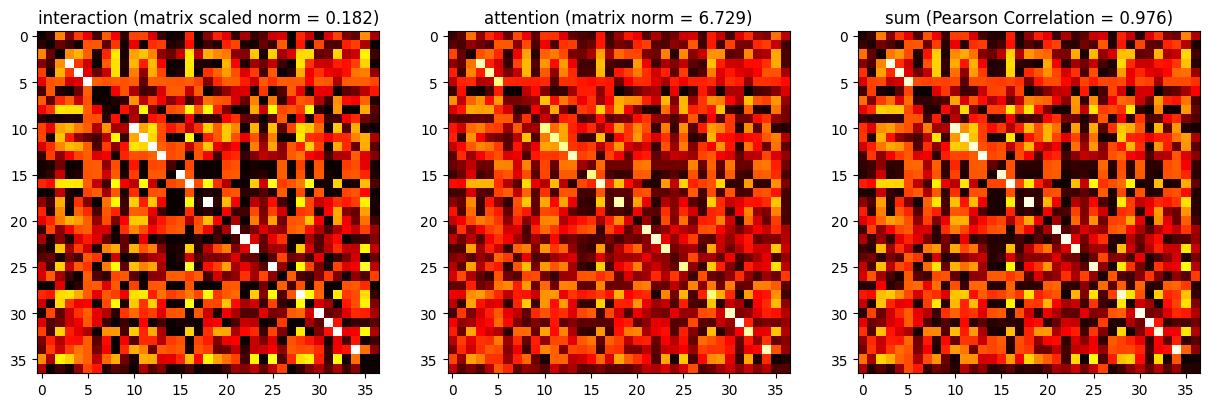

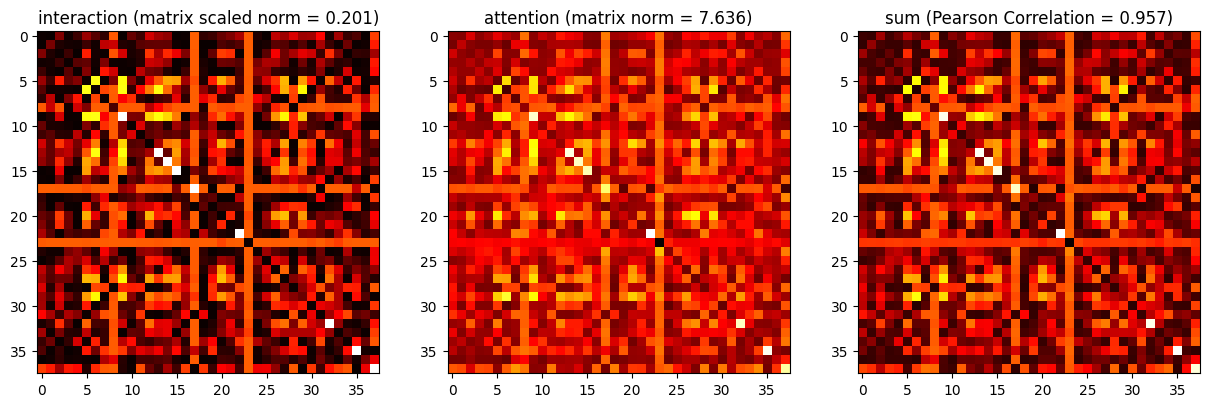

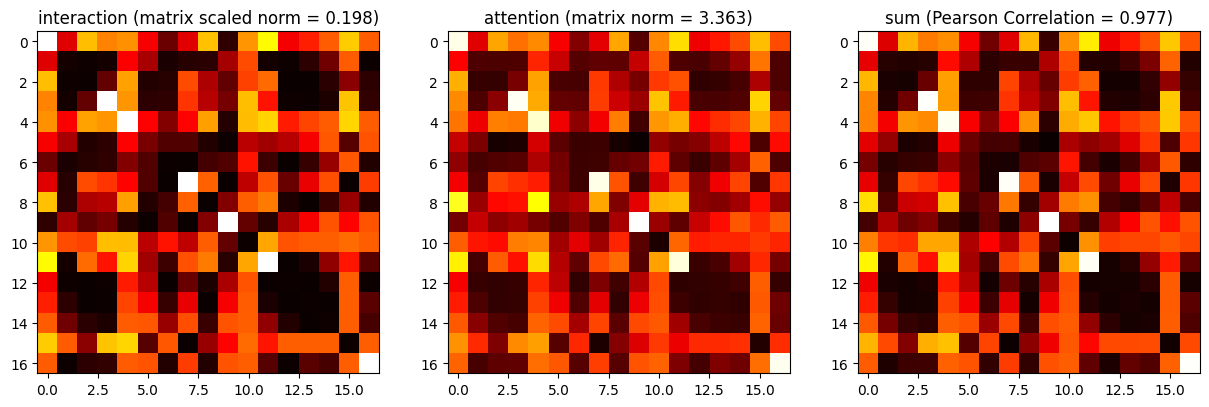

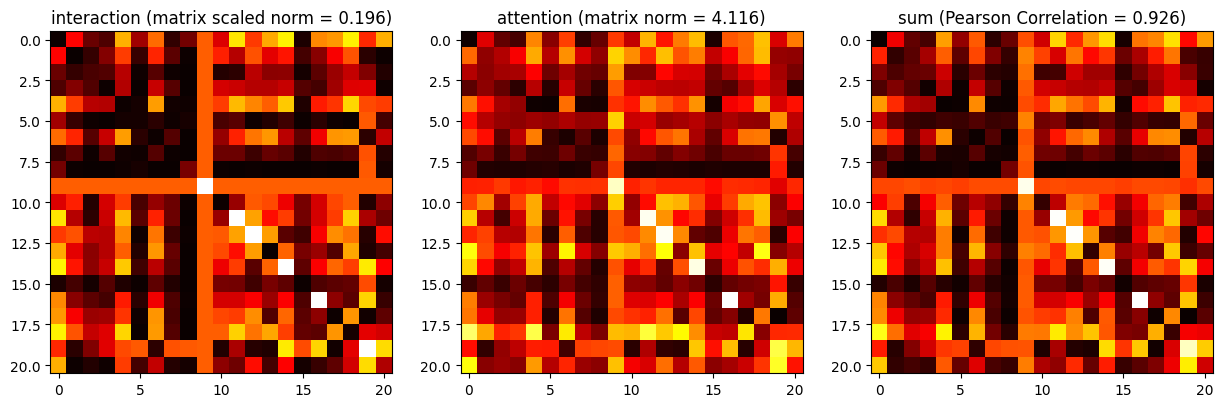

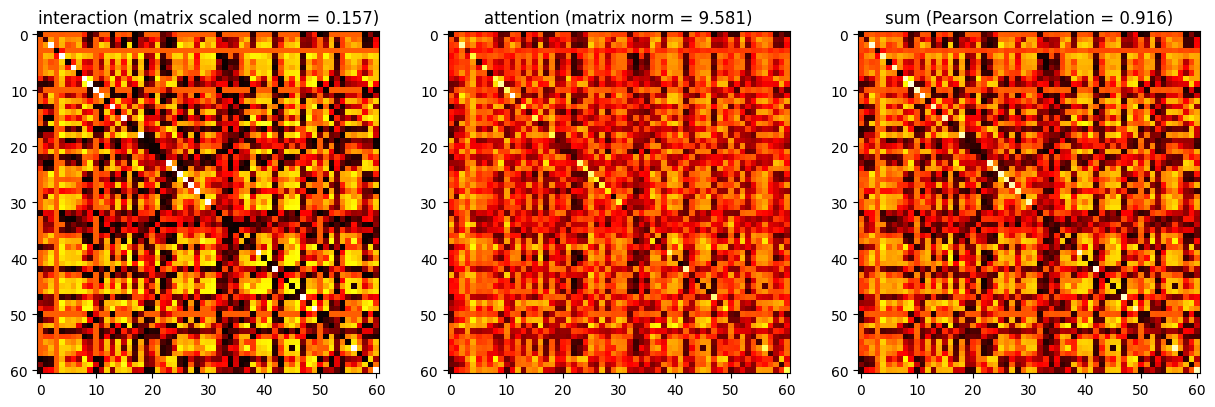

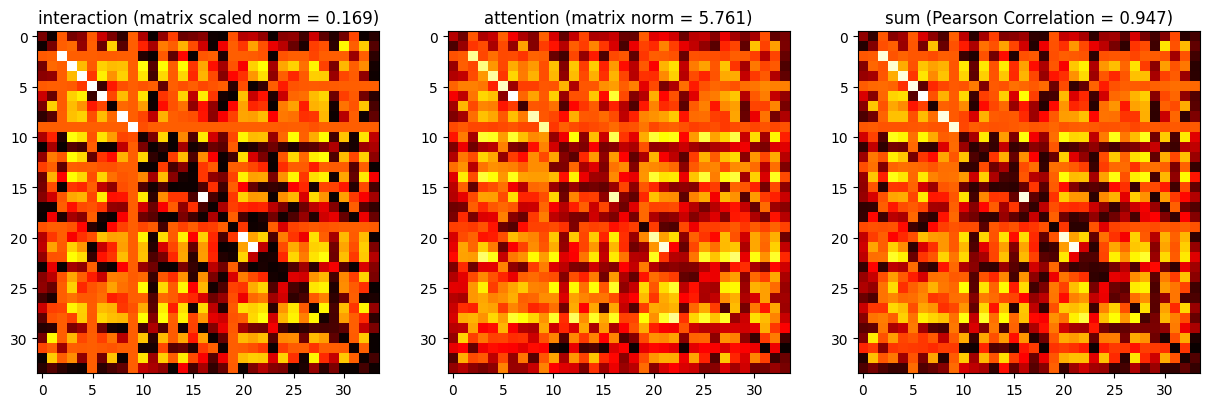

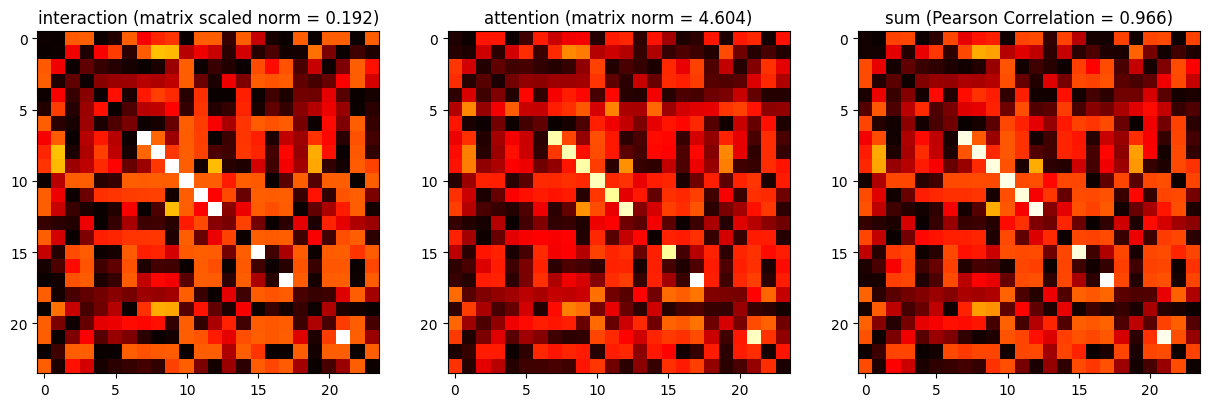

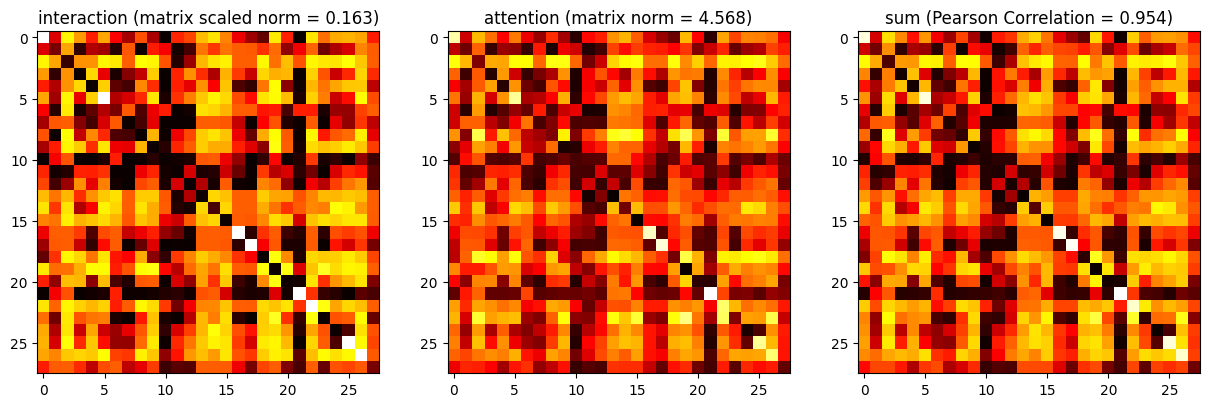

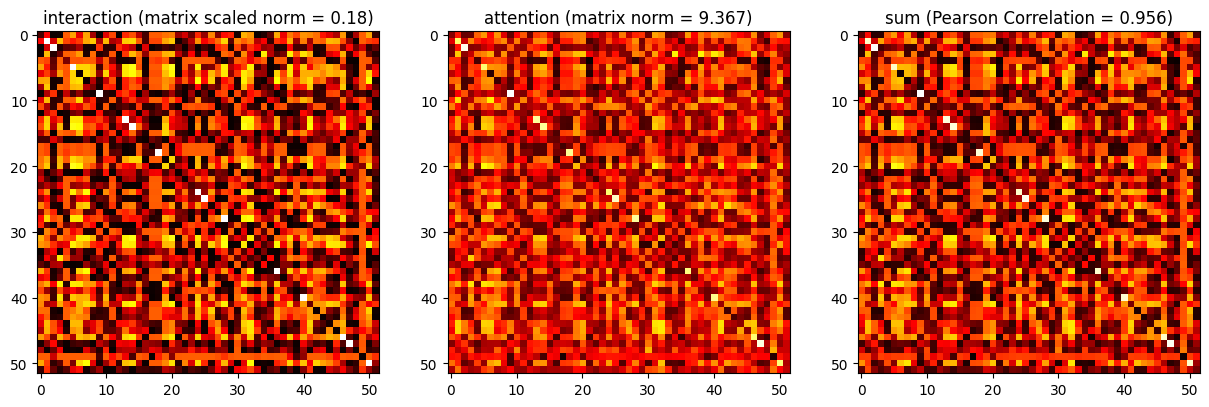

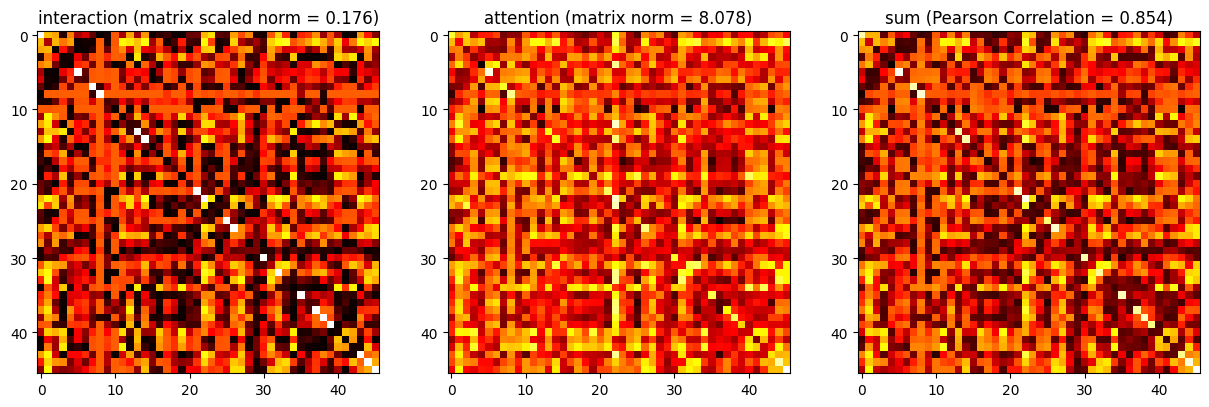

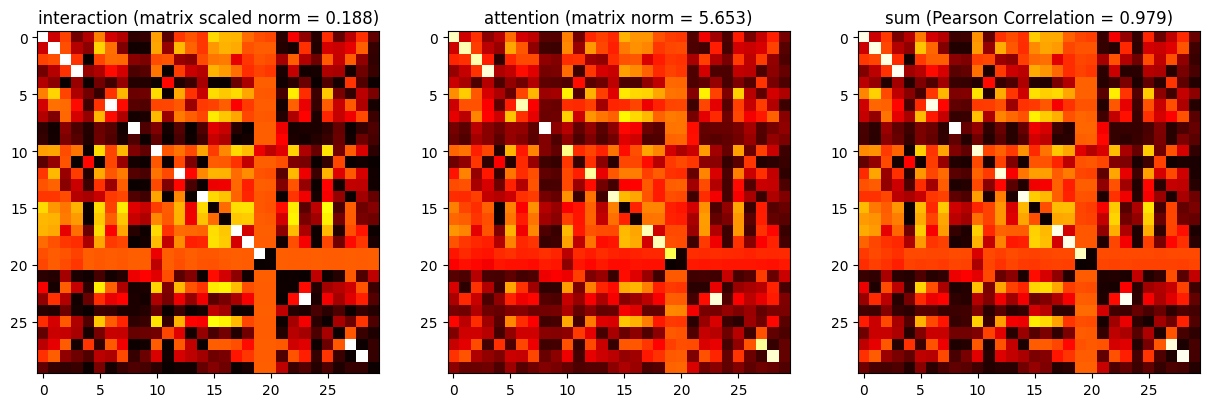

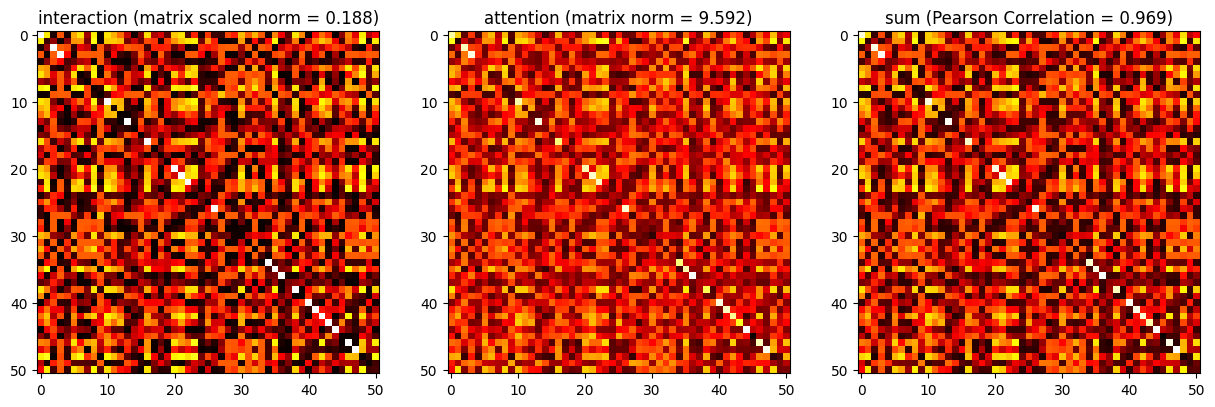

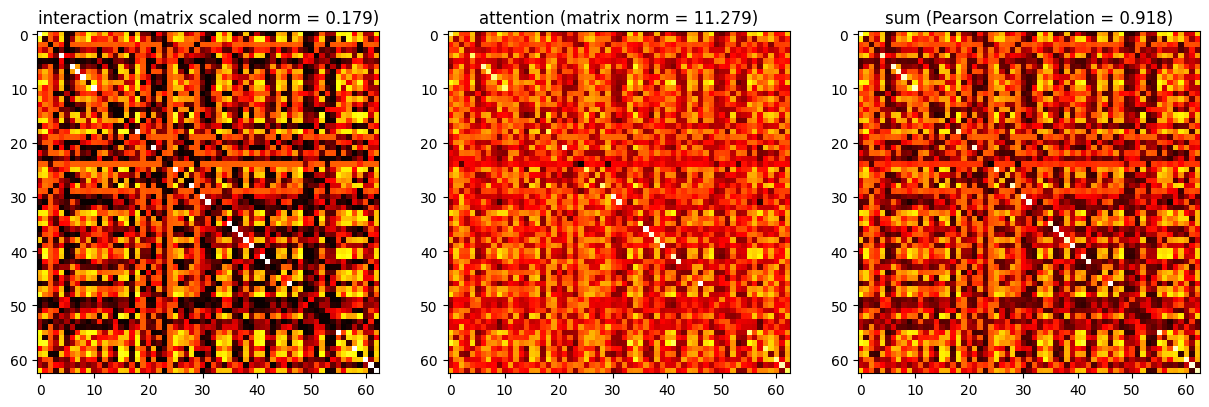

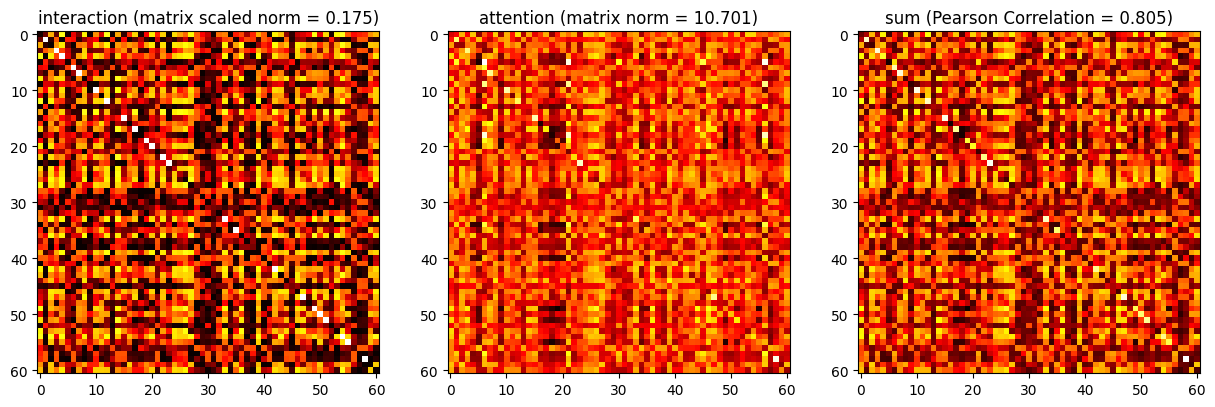

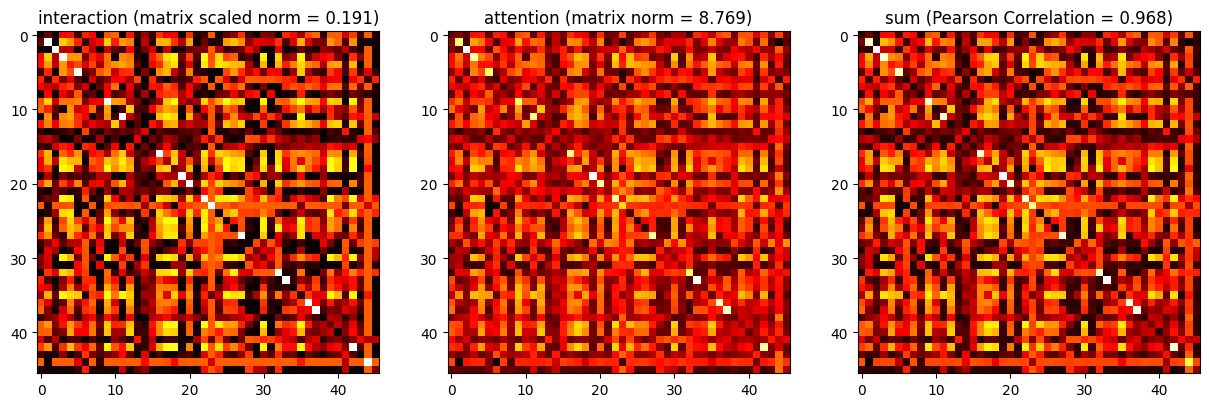

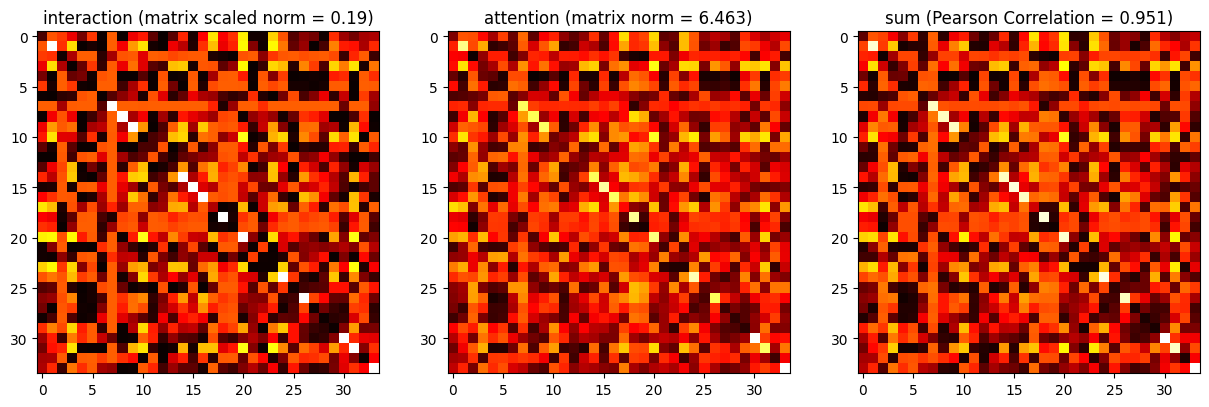

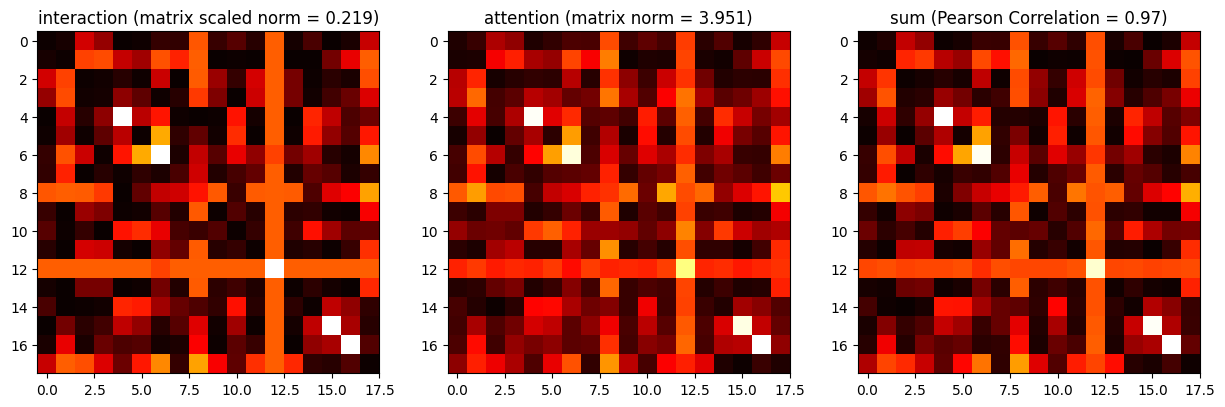

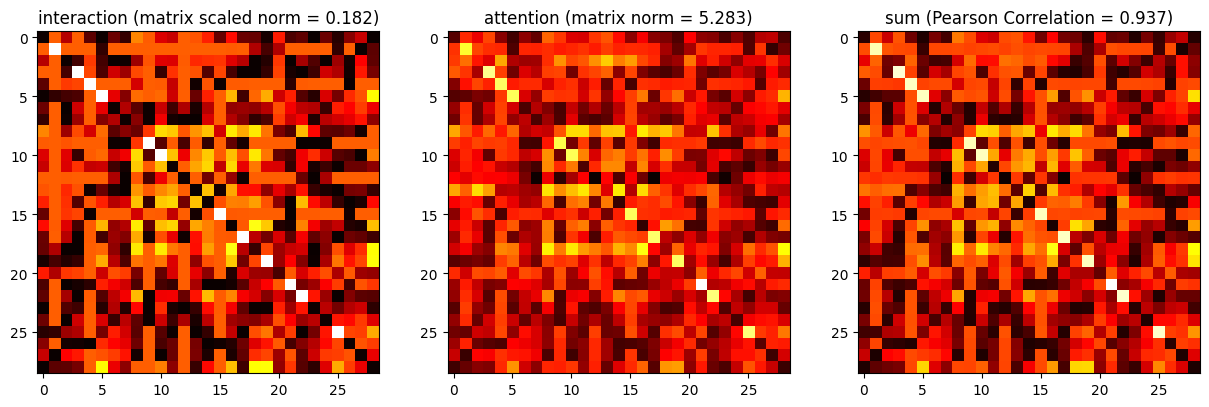

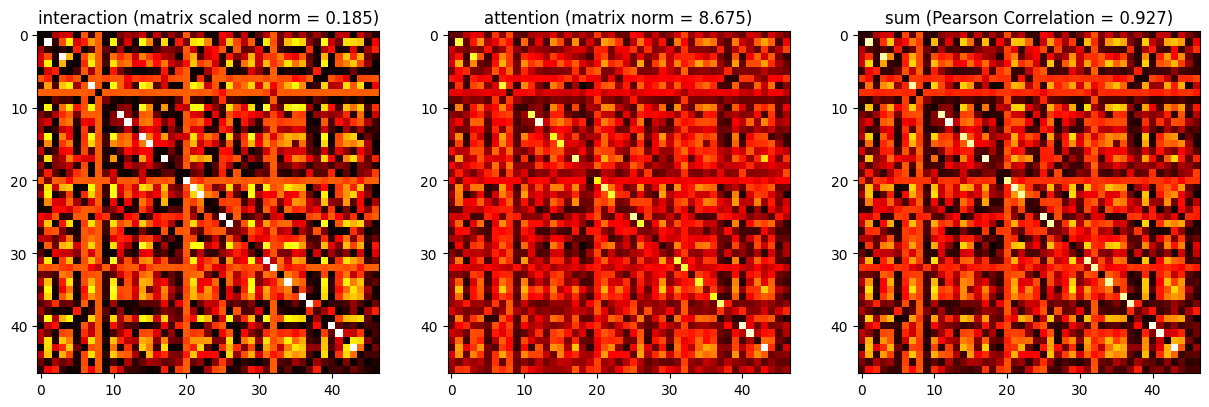

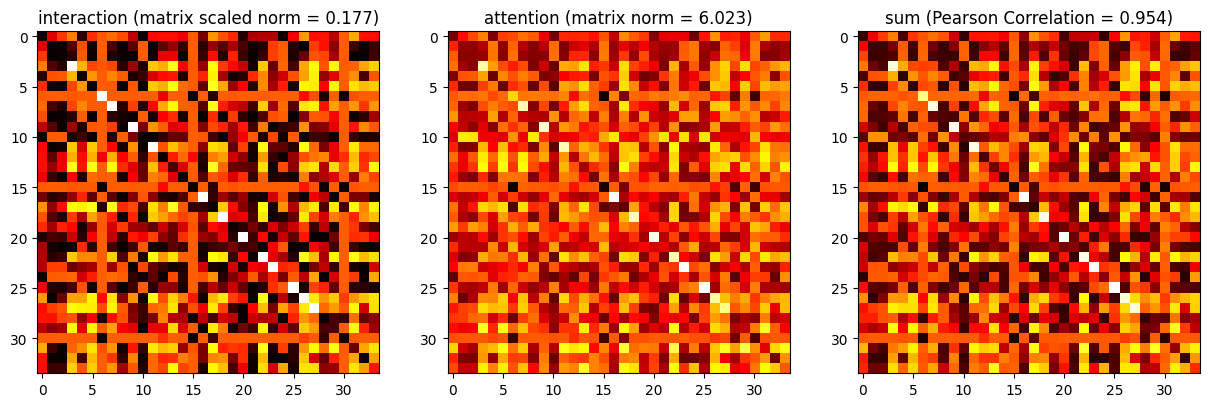

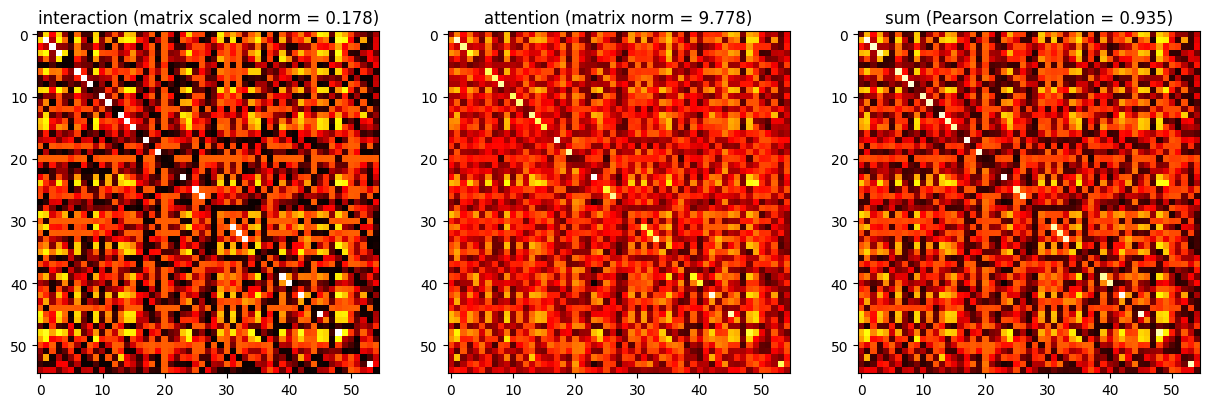

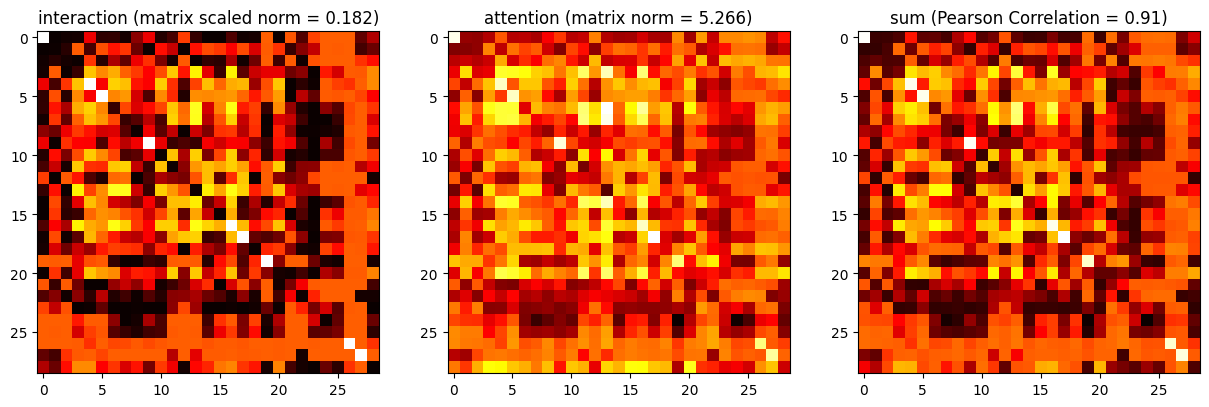

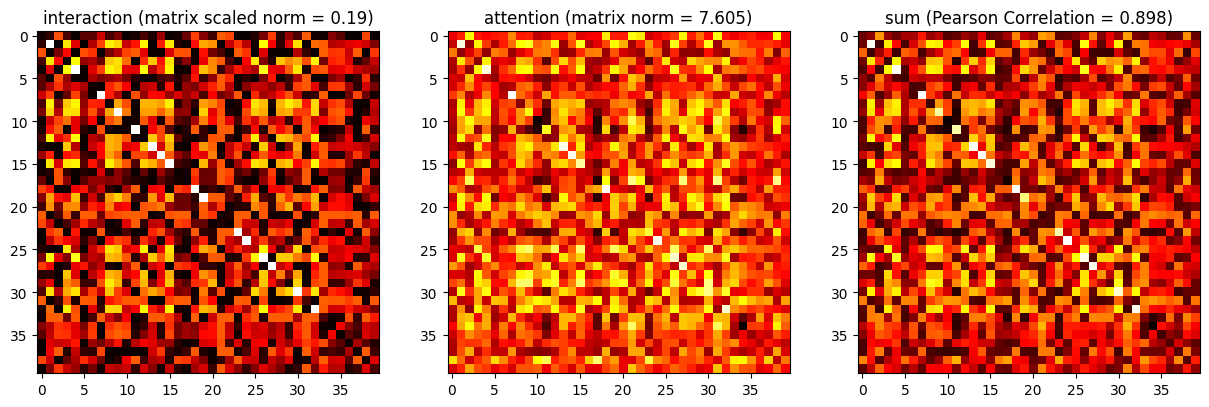

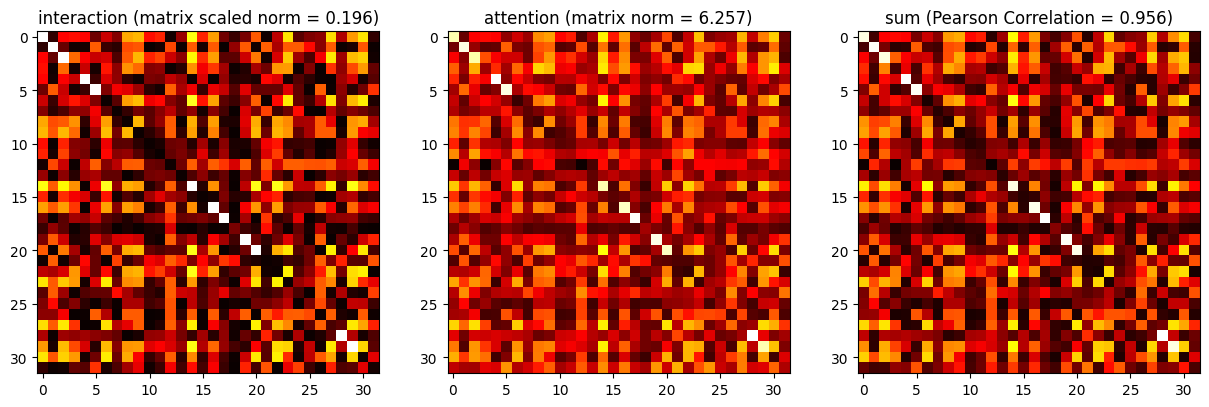

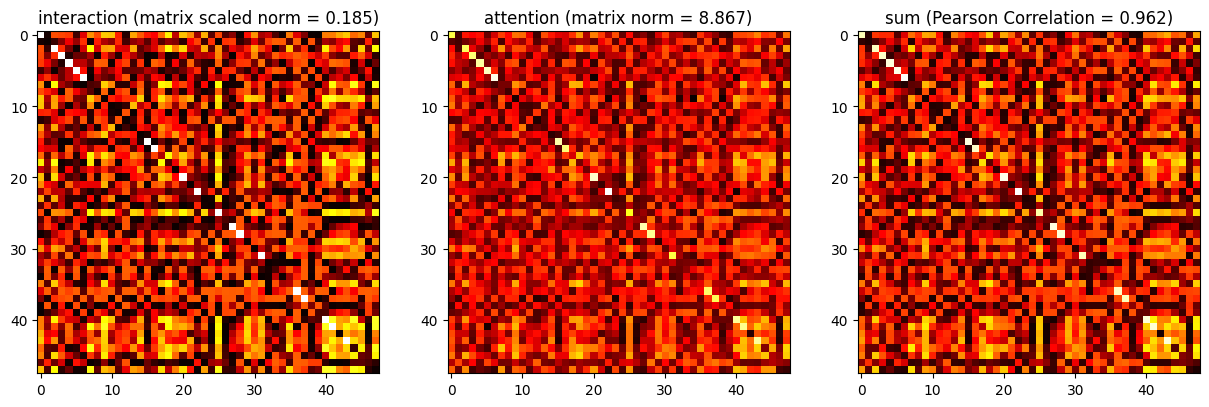

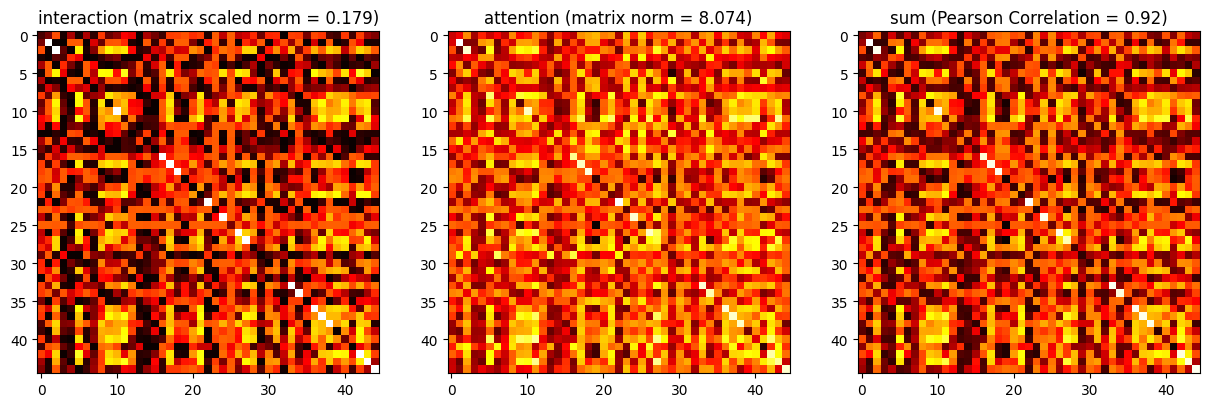

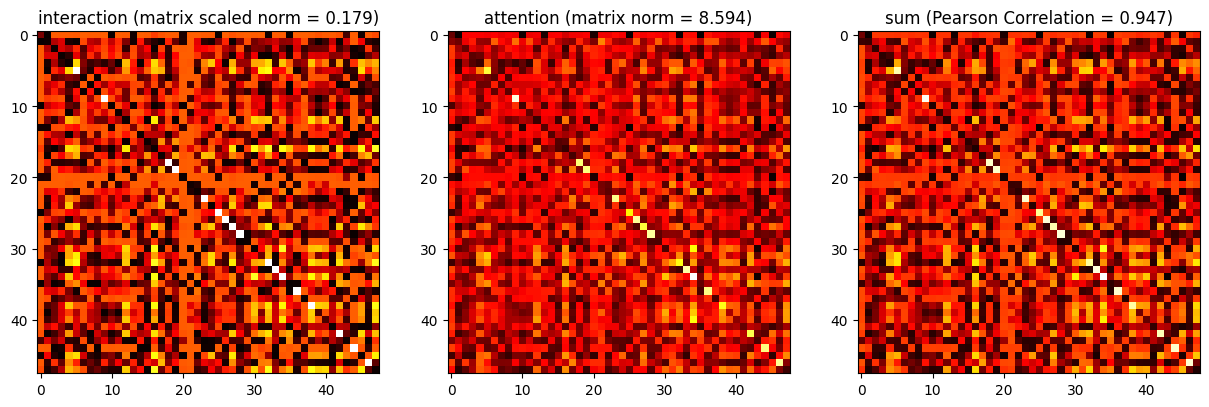

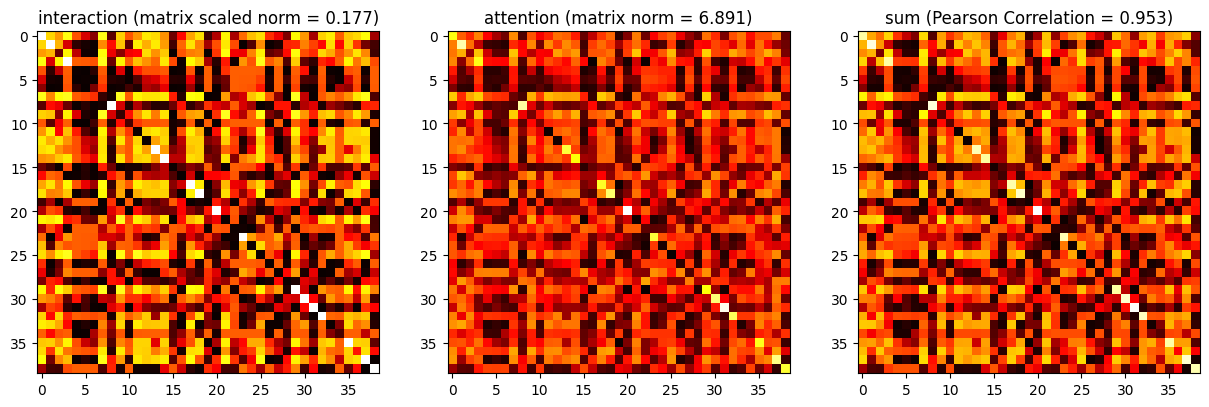

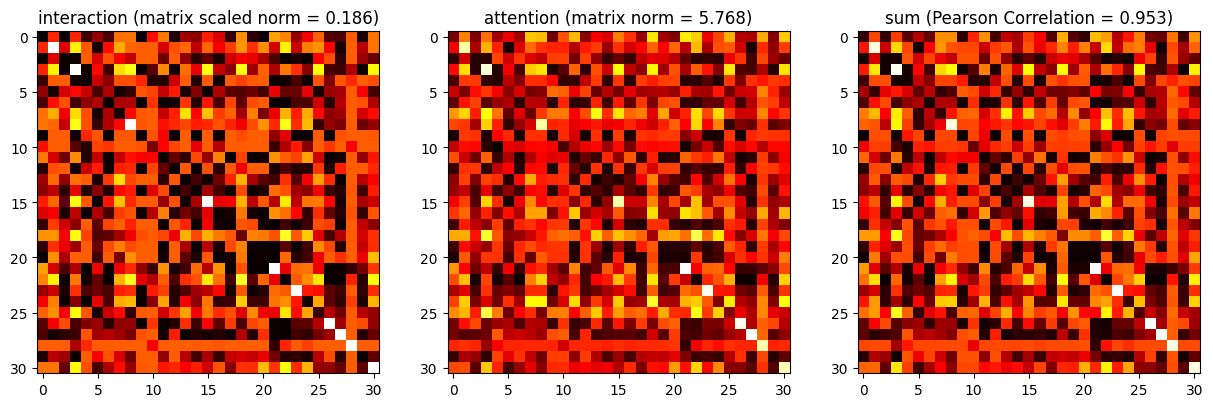

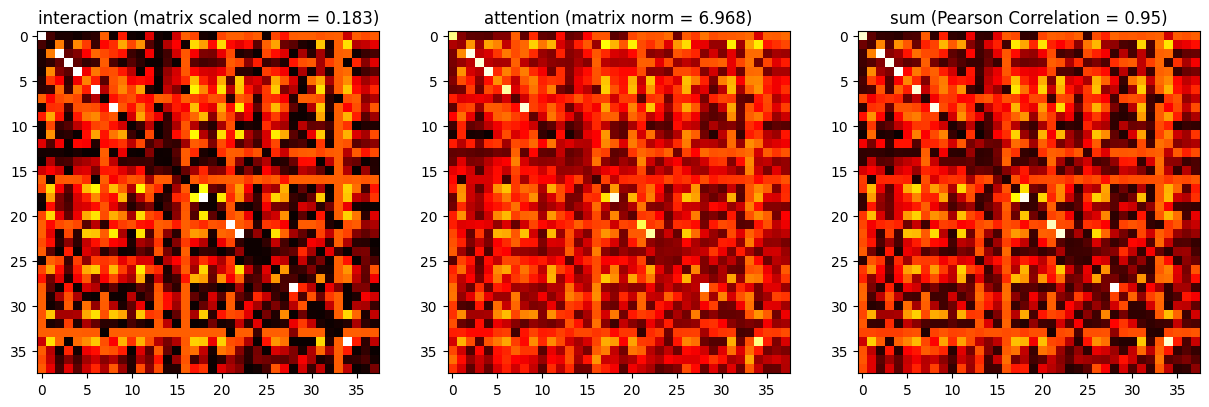

In [58]:
#model with pairs

for x in range(0,30):
    num = 0
    for b in np.squeeze(x_mask_test[x]):
        if b == 0:
            break
        num = num + 1

    pearson = scipy.stats.pearsonr(newInteraction[x,0:num,0:num].flatten(), newAttention[x,0:num,0:num].flatten())

    distance = np.linalg.norm(newInteraction[x,0:num,0:num] - newAttention[x,0:num,0:num])
    plt.figure(figsize = (15,15))
    plt.subplot(1, 3, 1)   
    plt.imshow(newInteraction[x,0:num,0:num],cmap = 'hot', interpolation = 'nearest')
    plt.title('interaction'+ ' (matrix scaled norm = ' + str(np.round(distance/num,3)) + ')')
   
    plt.subplot(1,3, 2)
    plt.imshow(newAttention[x,0:num,0:num],cmap = 'hot', interpolation = 'nearest')
    plt.title('attention' + ' (matrix norm = ' + str(np.round(distance,3)) + ')')
   
    plt.subplot(1,3,3)
    plt.imshow(newSum[x,0:num,0:num], cmap = 'hot', interpolation = 'nearest')
    plt.title('sum' + ' (Pearson Correlation = ' + str(np.round(pearson[0],3)) + ')')




    






In [46]:
torch.save(model,'torchModelLinformer')



In [34]:
import matplotlib.pyplot as plt

In [37]:
def learningCurve(trainloss,valloss):
    plt.figure(figsize=(10,8))
    plt.plot(trainloss)
    plt.plot(valloss)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    #plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

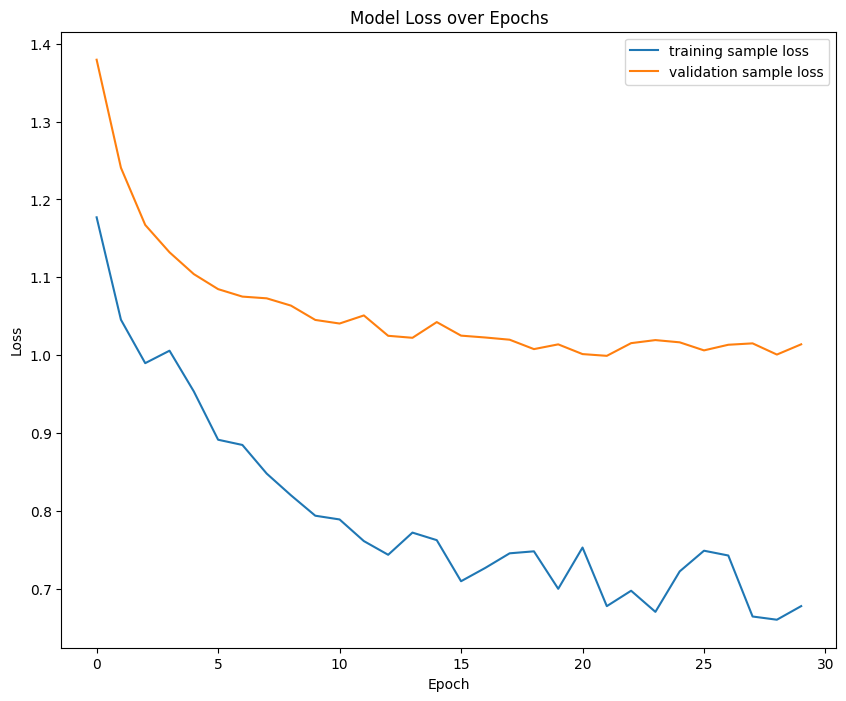

In [38]:
learningCurve(trainloss,valloss)


In [39]:
label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']


In [40]:
def makeRoc(features1,feat2,feat3,feat4, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    with torch.no_grad():

        labels_pred = model(torch.from_numpy(features1),torch.from_numpy(feat2),torch.from_numpy(feat3),torch.from_numpy(feat4))
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))       
    g = labels_pred.detach().numpy()
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = g[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'Linformer (No Pair) ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

In [41]:
import pandas as pd

2024-04-25 14:17:52 | INFO | numexpr.utils | Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-04-25 14:17:52 | INFO | numexpr.utils | NumExpr defaulting to 8 threads.


tensor([[-1.5795,  4.7080, -1.4816,  ..., -0.9110, -1.7781, -1.2026],
        [-3.0603, -1.2867,  0.8975,  ..., -0.0804,  0.7442,  0.8325],
        [ 6.3287, -1.9544, -0.4698,  ...,  2.6110, -0.8614, -3.1531],
        ...,
        [-2.1797, -2.3053,  1.1560,  ...,  1.2091,  0.3610,  0.3793],
        [-0.6401,  0.4495,  0.5392,  ...,  1.6347, -2.0531, -4.9078],
        [-2.5955, -0.7097, -0.1740,  ..., -1.0095, -0.6907,  7.3030]])

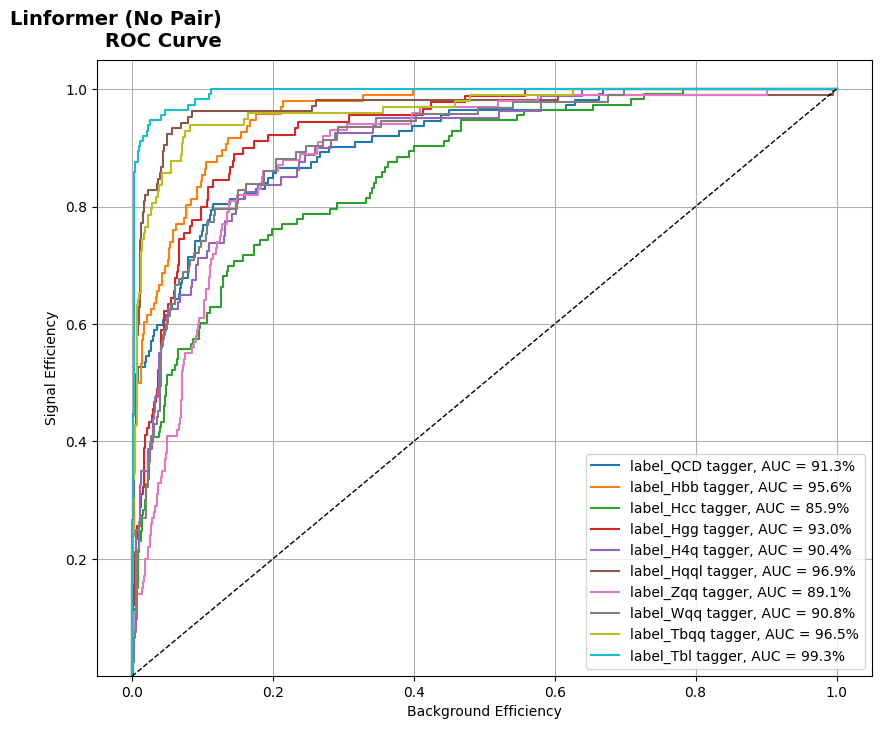

In [42]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)

tensor([[ 0.1898,  0.1171, -3.0622,  ...,  0.6715, -0.9102,  8.1219],
        [-1.5117,  1.6329,  6.0486,  ..., -3.7001, -0.4264, -2.9541],
        [-2.7562,  0.0865,  1.2654,  ..., -1.5413,  3.0243, -0.8610],
        ...,
        [-0.0690,  5.3414,  1.7180,  ..., -5.6761,  2.3389, -3.1653],
        [ 4.2917, -3.5000,  1.2488,  ...,  1.9530, -4.7770, -3.4524],
        [-0.4459,  4.9761, -0.6957,  ..., -3.4972,  1.2584,  6.5808]])

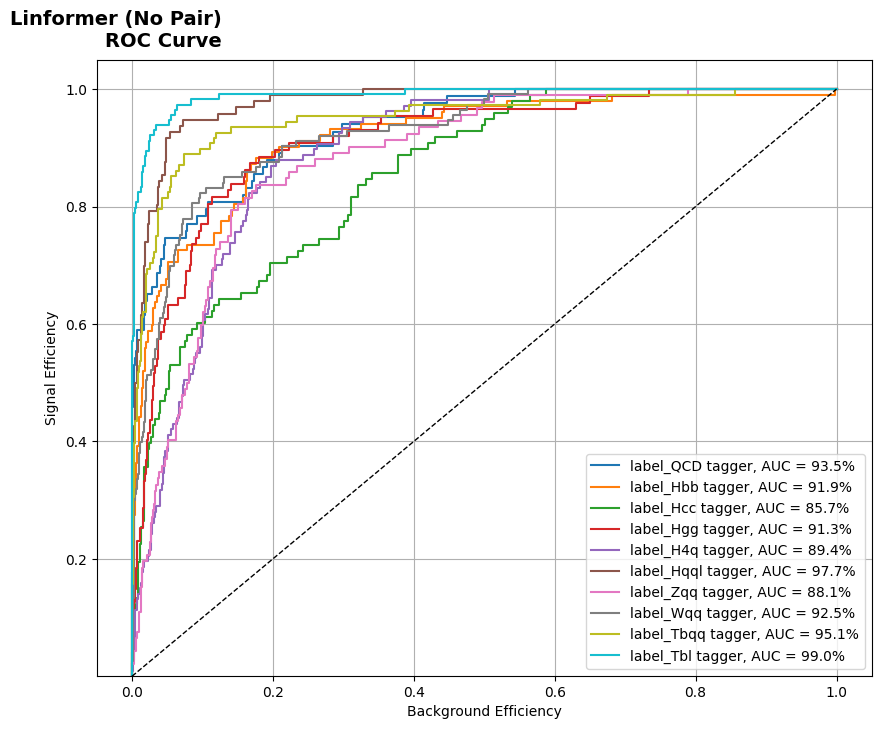

In [230]:
makeRoc(x_points_test,x_part_test,x_jet_test,x_mask_test,y_test,label_list, model)